# CS 445 Final Project: Video/Image Upsamling

### Setup

In [1]:
datadir = "./" 

utilfn = datadir + "utils.py"
imagesfn = datadir + "images"

In [2]:
import ffmpeg
import cv2
import numpy as np
import os
import numpy.linalg as la
import utils
%matplotlib inline
from matplotlib import pyplot as plt

from random import random
import time
import scipy
import scipy.ndimage as nd
import seaborn as sns
import pandas as pd
import scipy.sparse.linalg
from scipy import optimize
import pwlf

# Image Upsamling

### Read input image

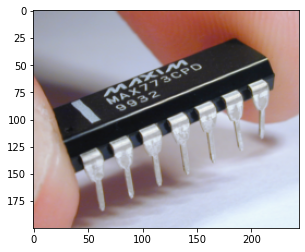

In [7]:
input_img_location = imagesfn + '/chip_input.png'
im1 = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(im1)

## 1. Initial Up-Sample using fast bicubic interpolation

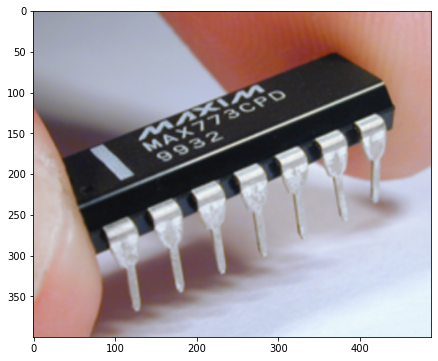

In [8]:
bicubic_im1 = cv2.resize(im1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(8, 6))
plt.imshow(bicubic_im1)

## 2. Feedback-control upsamling

## Deconvolution
***
### Compute image gradient density 

In [70]:
def compute_gradient(img):
#     f1 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
#     f2 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]]).T
    f1 = np.array([[-1], [0], [1]])
    f2 = np.array([[-1, 0, 1]])
    vert_gradient = cv2.filter2D(img, -1, f1)
    horz_gradient = cv2.filter2D(img, -1, f2)
    gradient = np.sqrt(np.square(vert_gradient) + np.square(horz_gradient))
    return gradient

In [71]:
gradient = compute_gradient(im1)
gradR = gradient[:,:,0]
gradG = gradient[:,:,1]
gradB = gradient[:,:,2]

In [72]:
gradR_norm = cv2.normalize(gradR, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
gradR_norm = gradR_norm.astype(np.uint8)

In [73]:
gradR_norm

array([[0, 1, 0, ..., 1, 4, 0],
       [1, 3, 3, ..., 1, 4, 1],
       [4, 5, 2, ..., 2, 3, 1],
       ...,
       [1, 1, 1, ..., 1, 0, 2],
       [0, 1, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 1, 0]], dtype=uint8)

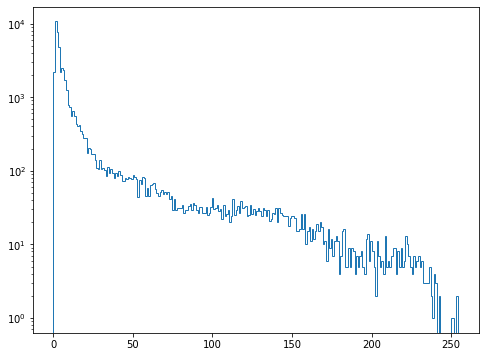

In [74]:
flatten_gradR = gradR_norm.flatten()
plt.figure(figsize=(8, 6))
counts, bins, bars = plt.hist(r, log=True, bins=256,range=(0,255),facecolor="r", histtype = 'step')
plt.show()

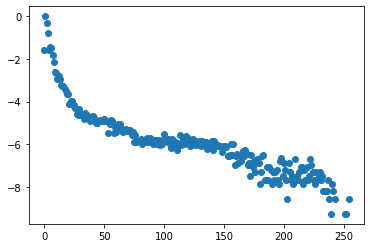

In [75]:
df = pd.Series(flatten_gradR).value_counts().reset_index()
df.columns = ['val', 'count']
val = np.array(df['val'])
log_count = np.log(df['count'] / df['count'].max())
plt.scatter(val, log_count)
plt.show()

In [76]:
my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
breaks = my_pwlf.fit(2)
print(breaks)
l_t = breaks[1]

[  0.          24.69166174 254.        ]


In [77]:
def piecewise(x, k, a, b):
    return np.piecewise(x, [x <= l_t, x > l_t], [lambda x: -k*abs(x), lambda x: -1 * (a * (x ** 2) + b)])

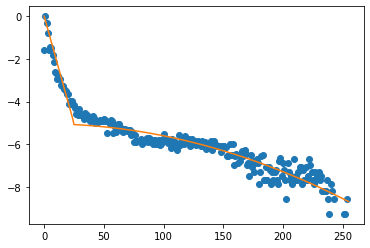

In [78]:
p , e = optimize.curve_fit(piecewise, val, log_count)
xd = np.linspace(0, 255, len(df['count']))
plt.plot(val,  log_count, "o")
plt.plot(xd, piecewise(xd, *p))
plt.show()

In [79]:
k, a, b = p[0], p[1], p[2]
print("k={:.10f}, a={:.10f}, b={:.10f}: ".format(k, a, b))

k=0.2010861286, a=0.0000560827, b=5.0471806594: 


In [80]:
def phi(x, l_t, k, a, b):
    if abs(x) <= l_t:
        return -k * abs(x)
    return -(a * x**2 + b)

In [90]:
def calculate_phi(gradient):
    l_t_arr = np.zeros(3)
    k_arr = np.zeros(3)
    a_arr = np.zeros(3)
    b_arr = np.zeros(3)
    for i in range(3):
        grad = gradient[:,:,i]
        grad_norm = cv2.normalize(grad, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
        grad_norm = grad_norm.astype(np.uint8)
        flatten_grad = grad_norm.flatten()
        df = pd.Series(flatten_grad).value_counts().reset_index()
        df.columns = ['val', 'count']
        val = np.array(df['val'])
        log_count = np.log(df['count'] / df['count'].max())
        my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
        breaks = my_pwlf.fit(2)
        l_t = breaks[1]
        p , e = optimize.curve_fit(piecewise, val, log_count)
        l_t_arr[i] = l_t
        k_arr[i], a_arr[i], b_arr[i] = p[0], p[1], p[2]
    return l_t_arr, k_arr, a_arr, b_arr
        

In [91]:
l_t_arr, k_arr, a_arr, b_arr = calculate_phi(gradient)

### Minimize Energy function

In [176]:
# according to https://dsp.stackexchange.com/questions/13720/convolution-theorem-with-a-kernel-smaller-than-the-image
# pad filter with zero 
def my_pading(fil, H_prime):
    f = np.zeros(H_prime.shape[:2])
    H_height, H_width = H_prime.shape[:2]
    fil_height, fil_width = fil.shape
    start_x = int((H_height - fil_height) / 2)
    start_y = int((H_width - fil_width) / 2)
    f[start_x: start_x + fil_height, start_y :start_y + fil_width] = fil
    return f

In [418]:
H_prime = bicubic_im1.copy()

sigma = 2
ksize = int(np.ceil(sigma)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

s1 = np.array(H_prime.shape[:2])
s2 = np.array(fil.shape)
size = s1 + s2 - 1

fsize = 2 ** np.ceil(np.log2(size)).astype(int)
fslice = tuple([slice(0, int(sz)) for sz in size])

# only compute filter and H_prime fft once
f_fft = np.fft.fft2(fil , fsize)
f_fft = f_fft[:,:,np.newaxis]
H_prime_fft = np.fft.fftn(H_prime, (fsize[0],fsize[1], 3))





In [396]:
np.conj(f_fft) * H_prime_fft

(512, 512, 3)

In [385]:
H = H_prime.copy()  # assume gaussian filter does nothing
f1 = np.array([[-1], [0], [1]])
f2 = np.array([[-1, 0, 1]])
H_x_gradient = cv2.filter2D(H, -1, f1)
H_y_gradient = cv2.filter2D(H, -1, f2)

lambda_1 = 0.3
lambda_2 = 20


In [386]:
H_x_gradient.max()

0.5111134248621323

- $\mu$ Step: fix$H$to optimize $\mu$
$$ E(\mu) = \lambda_1\parallel \Phi(\mu_x) \parallel_1 + \ \lambda_2\parallel \mu_x - \partial_x H \parallel_2^{2}$$
***
$$ \partial_x H \geq l_t : E(\mu) = \lambda_1| -k|\mu_x| | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
$$ \partial_x H < l_t : E(\mu) = \lambda_1| -(a \mu_x^2 + b) | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
By solving $\partial E(\mu)/ \partial \mu = 0$, we have
$$ \partial H \geq l_t : \mu = \frac{2 \lambda_2 \partial H \pm \lambda_1 k}{2 \lambda_2}$$
***
$$ \partial H < l_t : \mu = \frac{2 \lambda_2 \partial H}{2 \lambda_1 a + 2 \lambda_2}$$

In [430]:
# 𝜇 step
def mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient):
    mu_x = np.zeros(H_x_gradient.shape)
    mu_y = np.zeros(H_y_gradient.shape)
    height,width = H_x_gradient.shape[:2]

    for c in range(3):
        l_t = l_t_arr[c]
        k = k_arr[c] * 255
        a = a_arr[c] * (255**2)
        b = b_arr[c]
        for i in range(height):
            for j in range(width):
                curr_x_grad = H_x_gradient[i, j, c]
                curr_y_grad = H_y_gradient[i, j, c]
                
                if abs(curr_x_grad) >= l_t:
                    if curr_x_grad > 0:
                        mu_x[i,j,c] = ((2 * lambda_2 * curr_x_grad) - lambda_1 * k) / (2 * lambda_2)
                    else:
                        mu_x[i,j,c] = ((2 * lambda_2 * curr_x_grad) + lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_x[i,j,c] = (2 * lambda_2 * curr_x_grad) / (2 * lambda_1 * a + 2 * lambda_2)
                
                if abs(curr_y_grad) >= l_t:
                    if curr_y_grad > 0:
                        mu_y[i,j,c] = ((2 * lambda_2 * curr_y_grad) - lambda_1 * k) / (2 * lambda_2)
                    else:
                        mu_y[i,j,c] = ((2 * lambda_2 * curr_y_grad) + lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_y[i,j,c] = (2 * lambda_2 * curr_y_grad) / (2 * lambda_1 * a + 2 * lambda_2)
    
    return mu_x, mu_y
                

In [431]:
mu_x, mu_y = mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient)

In [432]:
(mu_x - H_x_gradient).max()

0.02860550086603919

- $H$ Step: fix$\mu$ to minimize$H$
$$ E(H) = \ \parallel f \otimes H - \tilde{H} \parallel_2^{2} + \ \lambda_2(\parallel \mu_x - \partial_x H \parallel_2^{2} + \parallel \mu_y - \partial_y H \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (9)$$
Using Plancherel’s theorem:
$$ E(H) = \ \parallel \mathcal{F}(f) \circ \mathcal{F}(H) - \mathcal{F}(\tilde{H}) \parallel_2^{2} + \ \lambda_2(\parallel \mathcal{F}(\mu_x) - \mathcal{F}(\partial_x) \circ \mathcal{F}(H) \parallel_2^{2} + \parallel \mathcal{F}(\mu_y) - \mathcal{F}(\partial_y) \circ \mathcal{F}(H) \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (10)$$

By setting $\partial E(H)/ \partial F(H) = 0$, we obtain an optimal $\mathcal{F}^{*}(H)$ that minimize $E(H)$:

$$
\mathcal{F}^{*}(H) = \frac
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(\tilde{H}) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\mu_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\mu_y)}
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(f) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\partial_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\partial_y)}
$$

where $\overline{(.)}$ is the conjucate operator and $\mathcal{F}$ is FFT operation.

Finally, $ H^{*} = \mathcal{F}^{-1}(\mathcal{F}^{*}(H)) $

In [433]:
def H_optimize(f_fft, H_prime_fft, fsize, fslice, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y):
    H_x_grad_fft = np.fft.fftn(H_x_gradient, (fsize[0],fsize[1], 3))
    H_y_grad_fft = np.fft.fftn(H_y_gradient, (fsize[0],fsize[1], 3))
    mu_x_fft = np.fft.fftn(mu_x, (fsize[0],fsize[1], 3))
    mu_y_fft = np.fft.fftn(mu_y, (fsize[0],fsize[1], 3))
    H_star_fft = (np.conj(f_fft) * H_prime_fft + lambda_2 * np.conj(H_x_grad_fft) * mu_x_fft + 
                  lambda_2 * np.conj(H_y_grad_fft) * mu_y_fft) / (np.conj(f_fft) * f_fft + 
                  lambda_2 * np.conj(H_x_grad_fft) * H_x_grad_fft + lambda_2 * np.conj(H_y_grad_fft) * H_y_grad_fft)
    H_star = np.fft.ifftn(H_star_fft)[fslice]
    H_star = H_star / H_star.max()
    H_star = np.clip(np.real(H_star),0,1)
    
    x_pad = int((H_star.shape[0] - mu_x.shape[0]) / 2)
    y_pad = int((H_star.shape[1] - mu_x.shape[1]) / 2)
    H_star = H_star[x_pad:-x_pad, y_pad:-y_pad,:]
    return H_star

In [434]:
H_star = H_optimize(f_fft, H_prime_fft,fsize, fslice, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

In [435]:
H_star.max()

0.00012800049145431783

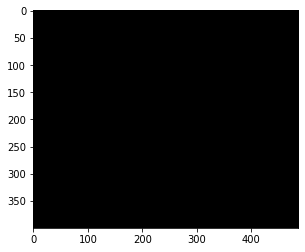

In [436]:
plt.figure()
plt.imshow(H_star)

In [241]:
x = [[1 , 0 , 0 , 0] , [0 , -1 , 0 , 0] , [0 , 0 , 3 , 0] , [0 , 0 , 0 , 1]]
x = np.array(x)
y = [[4 , 5] , [3 , 4]]
y = np.array(y)

print ("conv:" ,  signal.convolve2d(x , y , 'full'))

s1 = np.array(x.shape)
s2 = np.array(y.shape)

size = s1 + s2 - 1


fsize = 2 ** np.ceil(np.log2(size)).astype(int)
fslice = tuple([slice(0, int(sz)) for sz in size])


new_x = np.fft.fft2(x , fsize)


new_y = np.fft.fft2(y , fsize)
result = np.fft.ifft2(new_x*new_y)[fslice].copy()

print ("fft for my method:" , np.array(result.real , np.int32))

print ("fft:" , np.array(signal.fftconvolve(x ,y) , np.int32))

conv: [[ 4  5  0  0  0]
 [ 3  0 -5  0  0]
 [ 0 -3  8 15  0]
 [ 0  0  9 16  5]
 [ 0  0  0  3  4]]
fft for my method: [[ 4  5  0  0  0]
 [ 2  0 -5  0  0]
 [ 0 -3  8 15  0]
 [ 0  0  9 16  5]
 [ 0  0  0  3  4]]
fft: [[ 3  5  0  0  0]
 [ 2  0 -5  0  0]
 [ 0 -2  8 15  0]
 [ 0  0  9 16  4]
 [ 0  0  0  2  4]]


In [242]:
fsize

array([8, 8])

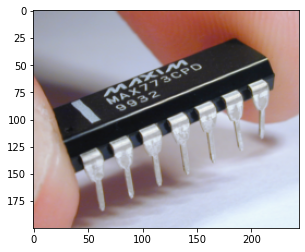

In [345]:
# how to do 3d fft convolution?

test_im = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(test_im)

sigma = 2
ksize = int(np.ceil(sigma)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

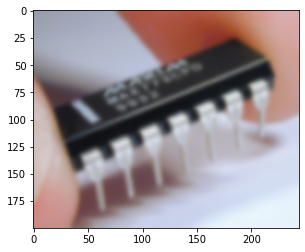

In [346]:
direct_fil_result = cv2.filter2D(test_im, -1, fil)
plt.figure()
plt.imshow(direct_fil_result)

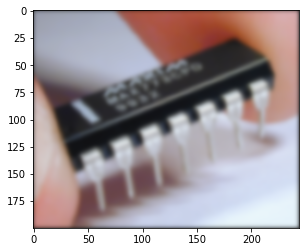

In [347]:
input_im = test_im.copy()
gauss_fil = fil

s1 = np.array(input_im.shape[:2])
s2 = np.array(gauss_fil.shape)
size = s1 + s2 - 1

fsize = 2 ** np.ceil(np.log2(size)).astype(int)
fslice = tuple([slice(0, int(sz)) for sz in size])

fil_fft = np.fft.fft2(gauss_fil , fsize)
im_fft = np.fft.fftn(test_im, (fsize[0],fsize[1], 3))

result = np.fft.ifftn(im_fft * fil_fft[:,:,np.newaxis])[fslice]
result = np.clip(np.real(result),0,1)

x_pad = int((result.shape[0] - r_channel.shape[0]) / 2)
y_pad = int((result.shape[1] - r_channel.shape[1]) / 2)

result = result[x_pad:-x_pad, y_pad:-y_pad,:]

plt.figure()
plt.imshow(result)

In [348]:
(direct_fil_result[20:-20,20:-20,:] - result[20:-20,20:-20,:]).max()

8.326672684688674e-16

## Re-convolution

## Pixel Substitution

## 3. Final Output

# Video Upsamling